<a href="https://colab.research.google.com/github/AgilAptanaDwiPutra/ProjectMachineLearning/blob/main/Tugas_Machine_Learning_1_Model_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARY

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 24.3 MB/s eta 0:00:00


In [2]:
# ============================
# Cell 1: Import Library
# ============================

import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

LOAD DATA

In [3]:
# ============================
# Cell 2: Load Data
# ============================

df = pd.read_excel("hasil_labelling.xlsx")

print(df.head())
print(df.columns)
print("Jumlah data awal:", len(df))

                                            subtitle    label
0  Presiden AS Donald Trump mengisyaratkan akan a...  politik
1  Netanyahu menyebut negara Palestina akan menja...   others
2  Netanyahu mengambil penerbangan lebih panjang ...  politik
3  Spanyol akan bergabung dengan Italia dalam men...  politik
4  Media terkemuka Israel menyoroti pidato Presid...  politik
Index(['subtitle', 'label'], dtype='object')
Jumlah data awal: 9479


Preprocessing

In [4]:
# ============================
# Cell 3: Preprocessing Teks
# ============================

def preprocess_text(text):
    text = str(text).lower()
    # hapus URL
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # hapus karakter selain huruf, angka, dan spasi
    text = re.sub(r"[^0-9a-zA-Z\s]", " ", text)
    # hapus spasi berulang
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Ganti 'subtitle' dengan nama kolom teks asli boss
df["subtitle_clean"] = df["subtitle"].apply(preprocess_text)

# Tokenisasi sederhana (bisa dianggap sebagai kolom 'stemming/tokens')
df["tokens"] = df["subtitle_clean"].apply(lambda s: s.split())

# Buang baris yang kosong / label hilang
df_model = df.dropna(subset=["subtitle_clean", "label"]).reset_index(drop=True)

print("Jumlah data setelah preprocessing:", len(df_model))

# Encode label jika masih string
if df_model["label"].dtype == "object":
    le = LabelEncoder()
    df_model["label_encoded"] = le.fit_transform(df_model["label"])
    y = df_model["label_encoded"].values
else:
    y = df_model["label"].values

num_classes = len(np.unique(y))

print("Contoh subtitle_clean:", df_model["subtitle_clean"].iloc[0])
print("Contoh tokens      :", df_model["tokens"].iloc[0])
print("Jumlah kelas       :", num_classes)

Jumlah data setelah preprocessing: 9479
Contoh subtitle_clean: presiden as donald trump mengisyaratkan akan adanya terobosan dalam krisis timur tengah dengan mengatakan semua pihak siap untuk sesuatu yang istimewa
Contoh tokens      : ['presiden', 'as', 'donald', 'trump', 'mengisyaratkan', 'akan', 'adanya', 'terobosan', 'dalam', 'krisis', 'timur', 'tengah', 'dengan', 'mengatakan', 'semua', 'pihak', 'siap', 'untuk', 'sesuatu', 'yang', 'istimewa']
Jumlah kelas       : 4


Fitur BoW & TF-IDF

In [5]:
# ============================
# Cell 4: Fitur BoW & TF-IDF
# ============================

def build_bow(
    texts,
    ngram_range=(1,1),
    max_features=None,
    min_df=1,
    max_df=1.0
):
    vec = CountVectorizer(
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df
    )
    X = vec.fit_transform(texts)
    return X, vec

def build_tfidf(
    texts,
    ngram_range=(1,1),
    max_features=None,
    min_df=1,
    max_df=1.0,
    sublinear_tf=True,
    norm="l2"
):
    tfidf = TfidfVectorizer(
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=sublinear_tf,
        norm=norm
    )
    X = tfidf.fit_transform(texts)
    return X, tfidf

texts = df_model["subtitle_clean"].tolist()

# --- BoW ---
X_bow, bow_vec = build_bow(texts)
X_bow_dense = X_bow.toarray().astype("float32")
print("BoW dense shape:", X_bow_dense.shape)

# --- TF-IDF ---
X_tfidf, tfidf_vec = build_tfidf(texts)
X_tfidf_dense = X_tfidf.toarray().astype("float32")
print("TF-IDF dense shape:", X_tfidf_dense.shape)

BoW dense shape: (9479, 15565)
TF-IDF dense shape: (9479, 15565)


Fitur Word2Vec (Doc Embedding Rata-rata)

In [6]:
# ============================
# Cell 5: Fitur Word2Vec
# ============================

def train_word2vec(
    sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10,
    seed=42
):
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg,
        seed=seed
    )
    model.train(sentences, total_examples=len(sentences), epochs=epochs)
    return model

def doc_average_embedding(tokens, w2v, vector_size):
    vecs = [w2v.wv[t] for t in tokens if t in w2v.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def build_doc_embeddings(tokens_list, w2v, vector_size):
    mat = np.vstack([
        doc_average_embedding(tokens, w2v, vector_size)
        for tokens in tokens_list
    ])
    return mat

sentences = df_model["tokens"].tolist()

w2v_model = train_word2vec(
    sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

vector_size = w2v_model.vector_size
X_w2v = build_doc_embeddings(sentences, w2v_model, vector_size=vector_size)
X_w2v = X_w2v.astype("float32")

print("Word2Vec doc-embedding shape:", X_w2v.shape)

Word2Vec doc-embedding shape: (9479, 300)


In [7]:
# =====================================
# Cell: Siapkan sequence untuk RNN
# =====================================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = df_model["subtitle_clean"].astype(str).tolist()

max_words = 20000    # ukuran vocab
max_len   = 100      # panjang maksimal sequence (kata)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
X_seq = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

print("Shape X_seq:", X_seq.shape)
print("Contoh sequence:", X_seq[0][:20])

Shape X_seq: (9479, 100)
Contoh sequence: [   9   21   75   39 5224   16  468 8734    7 2084   89   61   10   26
  453  148  669    6 3074    3]


Fungsi Umum untuk Model RNN

In [8]:
# ============================
# Cell 6: Fungsi RNN Umum (versi diperbaiki)
# ============================

from tensorflow.keras.layers import GRU, BatchNormalization

num_classes = len(np.unique(y))

def build_rnn_feature_model(input_dim, num_classes, rnn_units=128, dropout_rate=0.5):
    """
    Model DL untuk fitur vektor (BoW / TF-IDF / Word2Vec doc embedding)
    Di sini tetap diperlakukan sebagai sequence 1 time-step: (1, input_dim),
    tapi layer-nya kita perkuat (GRU + MLP).
    """
    # Deteksi binary vs multi-class
    if num_classes == 2:
        output_units = 1
        output_activation = "sigmoid"
        loss_fn = "binary_crossentropy"
    else:
        output_units = num_classes
        output_activation = "softmax"
        loss_fn = "sparse_categorical_crossentropy"

    model = Sequential([
        tf.keras.layers.Input(shape=(1, input_dim)),
        GRU(rnn_units, return_sequences=False),
        BatchNormalization(),
        Dense(128, activation="relu"),
        Dropout(dropout_rate),
        Dense(64, activation="relu"),
        Dropout(dropout_rate),
        Dense(output_units, activation=output_activation)
    ])

    model.compile(
        loss=loss_fn,
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model


def train_eval_rnn(X, y, test_size=0.2, val_size=0.1,
                   epochs=10, batch_size=64, name="MODEL"):
    """
    X: np.ndarray 2D (n_samples, n_features)
    y: np.ndarray 1D (label)
    """
    print(f"\n==============================")
    print(f"   TRAIN RNN UNTUK {name}")
    print(f"==============================")

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_size,
        random_state=42,
        stratify=y_train
    )

    # reshape ke (samples, time_steps=1, features)
    X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_rnn   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test_rnn  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = build_rnn_feature_model(input_dim=X.shape[1], num_classes=num_classes)

    history = model.fit(
        X_train_rnn, y_train,
        validation_data=(X_val_rnn, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # evaluasi
    y_pred_prob = model.predict(X_test_rnn)

    if num_classes == 2:
        # binary: sigmoid → threshold 0.5
        y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)
    else:
        # multi-class: softmax → argmax
        y_pred = np.argmax(y_pred_prob, axis=1)

    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred))

    print("=== CONFUSION MATRIX ===")
    print(confusion_matrix(y_test, y_pred))

    return model, history

Model RNN + BoW

In [9]:
# ============================
# Cell 7: RNN + BoW
# ============================

model_rnn_bow, history_rnn_bow = train_eval_rnn(
    X_bow_dense, y,
    epochs=15,
    batch_size=64,
    name="RNN + BoW"
)


   TRAIN RNN UNTUK RNN + BoW
Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.5095 - loss: 1.1494 - val_accuracy: 0.7945 - val_loss: 1.1287
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8398 - loss: 0.4307 - val_accuracy: 0.8300 - val_loss: 0.8280
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9291 - loss: 0.2202 - val_accuracy: 0.8235 - val_loss: 0.5691
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9561 - loss: 0.1355 - val_accuracy: 0.8261 - val_loss: 0.5024
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9741 - loss: 0.0871 - val_accuracy: 0.8129 - val_loss: 0.5353
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9816 - loss: 0.0631 - val_accuracy: 0.8379 - val_loss: 0.7599
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9809 - loss: 0.0631 - val_accuracy: 0.8314 - val_loss: 0.7780
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/ste

Model RNN + TF-IDF

In [10]:
# ============================
# Cell 8: RNN + TF-IDF
# ============================

model_rnn_tfidf, history_rnn_tfidf = train_eval_rnn(
    X_tfidf_dense, y,
    epochs=15,
    batch_size=64,
    name="RNN + TF-IDF"
)


   TRAIN RNN UNTUK RNN + TF-IDF
Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.5404 - loss: 1.0356 - val_accuracy: 0.6548 - val_loss: 1.0068
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.8773 - loss: 0.3262 - val_accuracy: 0.7062 - val_loss: 0.8868
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9544 - loss: 0.1466 - val_accuracy: 0.7365 - val_loss: 0.6831
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9703 - loss: 0.0940 - val_accuracy: 0.8076 - val_loss: 0.5322
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9809 - loss: 0.0597 - val_accuracy: 0.7971 - val_loss: 0.5745
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9870 - loss: 0.0436 - val_accuracy: 0.7997 - val_loss: 0.7461
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9821 - loss: 0.0559 - val_accuracy: 0.7787 - val_loss: 0.8684
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/s

Model RNN + Word2Vec (Doc Embedding)

In [11]:
# ============================
# Cell 9: RNN + Word2Vec
# ============================

model_rnn_w2v, history_rnn_w2v = train_eval_rnn(
    X_w2v, y,
    epochs=15,
    batch_size=64,
    name="RNN + Word2Vec"
)


   TRAIN RNN UNTUK RNN + Word2Vec
Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4994 - loss: 1.1398 - val_accuracy: 0.6377 - val_loss: 1.1958
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6424 - loss: 0.8062 - val_accuracy: 0.6957 - val_loss: 1.1122
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6731 - loss: 0.7271 - val_accuracy: 0.7049 - val_loss: 0.9434
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6928 - loss: 0.6987 - val_accuracy: 0.7141 - val_loss: 0.7960
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6989 - loss: 0.6957 - val_accuracy: 0.7260 - val_loss: 0.6856
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7075 - loss: 0.6668 - val_accuracy: 0.7431 - val_loss: 0.6388
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7378 - loss: 0.6333 - val_accuracy: 0.7431 - val_loss: 0.6333
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualisasi Training & Validation Loss/Accuracy

In [12]:
# ============================================
# Visualisasi Training–Validation Loss & Acc
# ============================================

import matplotlib.pyplot as plt

def plot_training_history(history, title="Model RNN"):
    """
    history: Keras History object (hasil training)
    """
    acc     = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss    = history.history.get("loss", [])
    val_loss= history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # ------------------- Accuracy -------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Accuracy")
    plt.plot(epochs_range, val_acc, label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # ------------------- Loss -------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


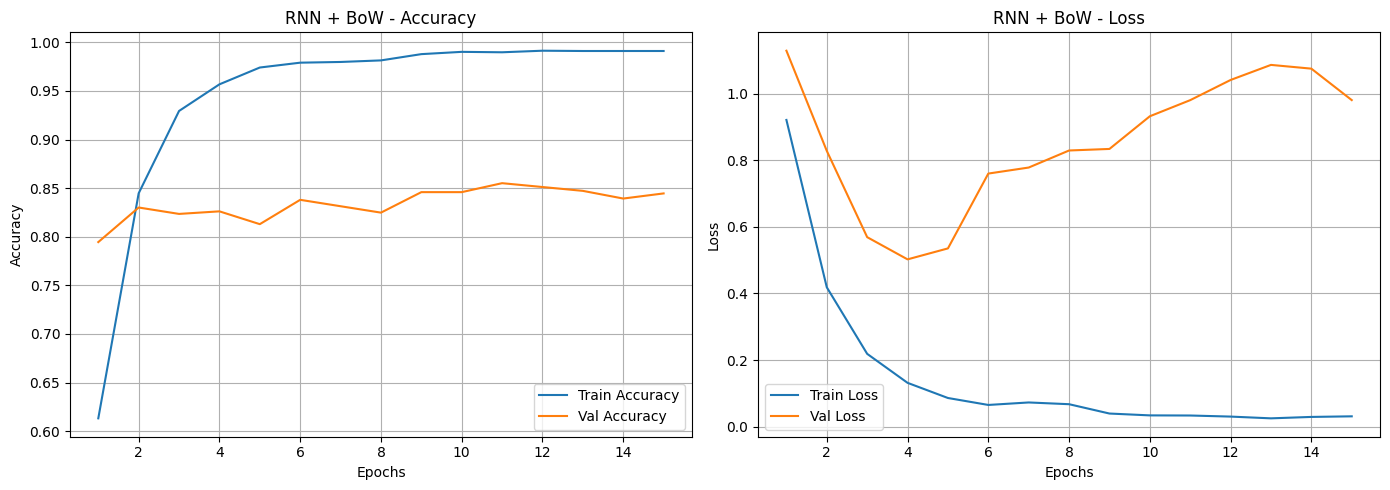

In [14]:
plot_training_history(history_rnn_bow, title="RNN + BoW")

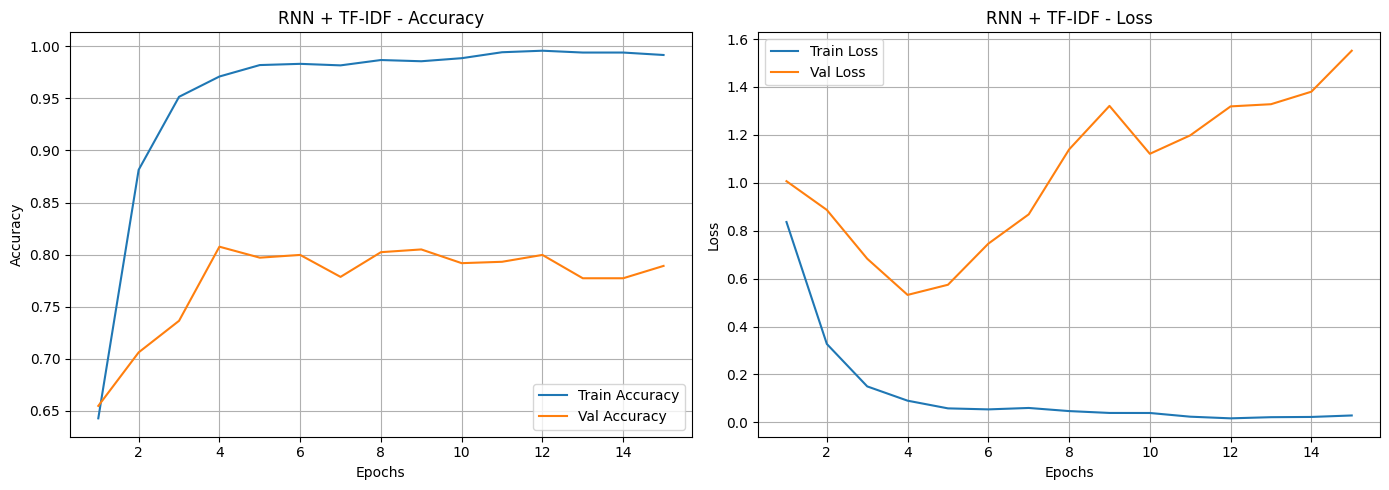

In [13]:
plot_training_history(history_rnn_tfidf, title="RNN + TF-IDF")

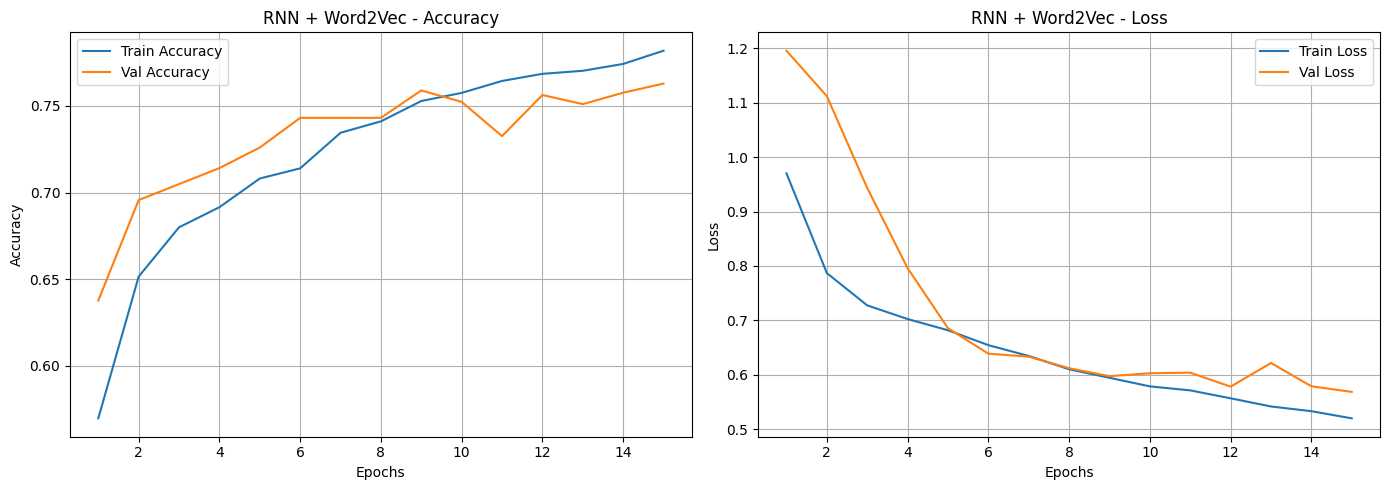

In [15]:
plot_training_history(history_rnn_w2v, title="RNN + Word2Vec")